#### Install requirements if needed

In [1]:
#!python -m pip install ipywidgets
#!pip install opencv-python
#!jupyter nbextension enable --py widgetsnbextension

In [2]:
# Setting a darker theme for my notebook!
#from jupyterthemes import get_themes
#import jupyterthemes as jt
#from jupyterthemes.stylefx import set_nb_theme
#set_nb_theme('monokai')

In [3]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import cv2
import time
import os
import shutil
from fnmatch import filter
from copy import deepcopy
from IPython.display import display, clear_output

### **Declare Your Parameters**

In [4]:
# Path to your images here:
source = "/home/affine/Documents/petfinder"

In [5]:
# Name your classes here:
classes = ['Cat', 'Dog', 'Hamster', 'Bird', 'Cow']

### Functional codes (Just run all this blindly!)

In [6]:
buttons = []
for clss in classes:
    buttons.append(widgets.Button(description=clss))

prev_button = widgets.Button(description='PREV', layout = widgets.Layout(width='10%'))
prev_button.style.button_color = 'lightblue'
prev_button.style.font_weight = 'bold'
    
next_button = widgets.Button(description='NEXT', layout = widgets.Layout(width='80%'))
next_button.style.button_color = 'lightgreen'
next_button.style.font_weight = 'bold'

undo_button = widgets.Button(description='UNDO', layout = widgets.Layout(width='10%'))
undo_button.style.button_color = 'lightcoral'
undo_button.style.font_weight = 'bold'

hbox1 = widgets.HBox(buttons)
hbox2 = widgets.HBox([prev_button, next_button, undo_button])
box = widgets.VBox([hbox1, hbox2])

In [7]:
def get_img_labels(labels_2_img):
    img_labels = {}
    for label, fnames in labels_2_img.items():
        for fname in fnames:
            if fname not in img_labels.keys():
                img_labels[fname] = [label]
            else:
                img_labels[fname].append(label)
    
    return img_labels

In [8]:
tags = []
def add_2_class(b, clss):
    global tags
    fname = img_files[ix]
    
    if clss in tags:
        print(f"Label {clss} for {fname} already exists!")
        return
    
    tags.append(clss)
    segr_map[clss].append(fname)
    print(f"Added {fname} to {clss}.")

In [9]:
def show_prev(b=None):
    global ix, tags
    if ix > 0:
        ix -= 1
        fname = img_files[ix]
    else:
        print("\nNO PREViOUS FiLE!!")
        return
    clear_output()
    
    try:
        tags = get_img_labels(segr_map)[fname]
    except KeyError:
        tags = []
    
    print(f"Index: {ix}\nFilename: {fname}")
    img = cv2.cvtColor(cv2.imread(os.path.join(source, fname)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    display(box)
    
    if len(tags) > 0: 
        print(f"Labels added previously: {tags}")

In [10]:
def show_next(b=None):
    global ix, tags
    if ix < len(img_files)-1:
        ix += 1
        fname = img_files[ix]
    else:
        print("\nALL FiLES REViEWED!!")
        return
    clear_output()
    
    try:
        tags = get_img_labels(segr_map)[fname]
    except KeyError:
        tags = []
    
    print(f"File No.: {ix}\nFilename: {fname}")
    img = cv2.cvtColor(cv2.imread(os.path.join(source, fname)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    display(box)
    
    if len(tags) > 0: 
        print(f"Labels added previously: {tags}")

In [11]:
def undo(b=None):
    global tags
    if len(tags) < 1:
        return
    fname = img_files[ix]
    segr_map[tags[-1]].remove(fname)
    print(f"Removed {fname} from {tags[-1]}")
    tags = tags[:-1]

In [12]:
i = 0
while True:
    try:
        print(f"Adding action for {classes[i]} button...")
        exec(f"buttons[{i}].on_click(lambda b: add_2_class(b, classes[{i}]))")
    except IndexError:
        break
    i += 1
prev_button.on_click(show_prev)
next_button.on_click(show_next)
undo_button.on_click(undo)

Adding action for Cat button...
Adding action for Dog button...
Adding action for Hamster button...
Adding action for Bird button...
Adding action for Cow button...


In [13]:
img_files = filter(os.listdir(source), '*.jpg')

### Start the Labelling Tool

File No.: 14
Filename: 39f01e829-1.jpg


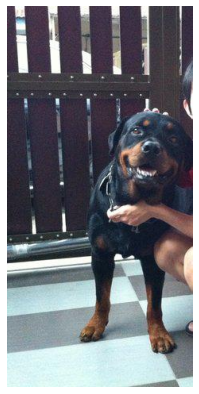

In [14]:
segr_map = {k: [] for k in classes}
ix = -1
show_next()

### Display Counts

In [15]:
for cls in classes:
    print(f"Number of images in {cls} are: {len(segr_map[cls])}")

Number of images in Cat are: 3
Number of images in Dog are: 4
Number of images in Hamster are: 0
Number of images in Bird are: 0
Number of images in Cow are: 0


In [16]:
combined = []
for _, flist in segr_map.items():
    combined.extend(flist)
    
print(f"Number of images segregated: {len(set(combined))}")

Number of images segregated: 7


### Segregate Into Directories

In [17]:
for clss in segr_map.keys():
    os.makedirs(os.path.join(source, clss), exist_ok=True)
    for fname in segr_map[clss]:
        shutil.copy2(os.path.join(source, fname), os.path.join(source, clss, fname))

### Did you miss any images? Go label them as well...

In [18]:
remaining_images = [f for f in img_files if f not in set(combined)]
print(f"Images remaining to be segregated: {len(remaining_images)}")

Images remaining to be segregated: 14458


In [19]:
if len(remaining_images)>0:
    img_files = remaining_images

#### Now go run the segregator cell again to label remaining images (if any).
__________________________________________________________________________________________

### Create Labels csv file

##### Mention path to save your labels file:

In [20]:
output_path = "/home/affine/Documents/petfinder"

##### ... and then run the below cells!

In [21]:
img_labels = get_img_labels(segr_map)
        
len(img_labels.keys())

7

In [22]:
with open(os.path.join(output_path, "image_labels.csv"), 'w+') as csv_file:
    print("image,"+",".join([f"label_{i}" for i in range(len(classes))]), file=csv_file)
    for fname, label_list in img_labels.items():
        print(f"{fname},"+",".join(label_list), file=csv_file)